In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

try:
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import StratifiedKFold
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

In [137]:
df = pd.read_csv('train.csv', sep=',', header = 0, index_col = 0, encoding='utf8')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24712 entries, df7489733b004bbe40d3d37b34f82419 to 46d0d25dfd1def79632dd437261d0b5c
Data columns (total 21 columns):
age               24712 non-null int64
job               24712 non-null object
marital           24712 non-null object
education         24712 non-null object
default           24712 non-null object
housing           24712 non-null object
loan              24712 non-null object
contact           24712 non-null object
month             24712 non-null object
day_of_week       24712 non-null object
duration          24712 non-null int64
campaign          24712 non-null int64
pdays             24712 non-null int64
previous          24712 non-null int64
poutcome          24712 non-null object
emp.var.rate      24712 non-null float64
cons.price.idx    24712 non-null float64
cons.conf.idx     24712 non-null float64
euribor3m         24712 non-null float64
nr.employed       24712 non-null float64
target            24712 non-null int64

In [43]:
# Смотрим долю целевых значений
df['target'].value_counts()
# Очень грустно, что с этим делать непонятно

0    21925
1     2787
Name: target, dtype: int64

In [159]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,24712,NaN,NaN,NaN,40.0302,10.4623,17,32,38,47,98
job,24712,12,admin.,6254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,24712,4,married,14871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,24712,8,university.degree,7309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,24712,3,no,19567,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,24712,3,yes,12934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,24712,3,no,20334,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,24712,2,cellular,15729,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,24712,10,may,8199,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,24712,5,thu,5144,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
# Состав категорий 
for i in df.columns:
    if str(df[i].dtype) == 'object' and i != '_id':
        print('='*10)
        print(i)
        print(df[i].value_counts(), '\n', df.loc[df['target']==1, i].value_counts())
        print('\n')

job
admin.           6254
blue-collar      5621
technician       3987
services         2391
management       1758
retired          1001
entrepreneur      853
self-employed     850
housemaid         652
unemployed        594
student           554
unknown           197
Name: job, dtype: int64 
 admin.           825
technician       429
blue-collar      404
retired          240
management       203
services         189
student          167
self-employed     87
unemployed        86
entrepreneur      73
housemaid         64
unknown           20
Name: job, dtype: int64


marital
married     14871
single       7041
divorced     2755
unknown        45
Name: marital, dtype: int64 
 married     1507
single       983
divorced     291
unknown        6
Name: marital, dtype: int64


education
university.degree      7309
high.school            5737
basic.9y               3565
professional.course    3112
basic.4y               2523
basic.6y               1399
unknown                1060
illiterate    

In [185]:
## Подготовка данных для knn
def preproc(df_init):
    df_preproc = df_init.copy()
# Закодируем все категориальные призаки количеством их значений
    for i in df_preproc.columns:
        if str(df_preproc[i].dtype) == 'object':
            df_preproc[i + '_code']=df_preproc[i].map(df_preproc.groupby(i)['age'].count())
            df_preproc = df_preproc.drop(i, axis=1)
# Нормализуем значения признаков
    Scaler = StandardScaler()
    col = df_preproc.columns
#    col = col.drop('target')
    df_preproc[col] = Scaler.fit_transform(df_preproc[col])  
    return df_preproc

def preproc_oh(df_init):
    df_output = df_init.copy()
# Закодируем все категориальные призаки через one hot
    # 3. Редкие категиории (<10% от всего) переименовываем в "Прочие" 
    Kat = df_output.columns
    for i in df_output.columns:
        if str(df_output[i].dtype) != 'object':
            Kat = Kat.drop(i) 
    for j in Kat:
        KatVal = df_output[j].value_counts()
        KatVal_Other = KatVal.index
    # Находим значения категорий с показателем <10% от "всего"
        for i in KatVal.index:
            if KatVal[i] > KatVal.sum()*0.1:
                KatVal_Other = KatVal_Other.drop(i) 
    #Значения категорий с количеством =<10% переименовываем в прочие
    #Криво, кончно, можно в одном цикле всё сделать
        for i in KatVal_Other:
            df_output.loc[:,j] = df_output.loc[:,j].replace({i: 'Прочее'})
    #Замена категориальных признаков, one hot
    Kat = df_output.columns
    for i in df_output.columns:
        if str(df_output[i].dtype) != 'object':
            Kat = Kat.drop(i) 
    # Перебираем все категории и заменяем их столбцами OneHotEncoding
    for j in Kat:
        for i in df_output[j].unique():
            df_output[j + '=' + i] = (df_output[j] == i).astype(float)
        df_output = df_output.drop(j, axis=1)

# Нормализуем значения признаков
    Scaler = StandardScaler()
    col = df_output.columns
#    col = col.drop('target')
    df_output[col] = Scaler.fit_transform(df_output[col])  
    return df_output

In [187]:
x = df.drop('target', axis=1)
y = df['target']
x = preproc(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# Для oh
x_oh = df.drop('target', axis=1)
y_oh = df['target']
x_oh = preproc_oh(x_oh)

x_train_oh, x_test_oh, y_train_oh, y_test_oh = train_test_split(x_oh, y_oh, test_size=0.33, random_state=42)

0.9202407386639749
0.8864494037606071


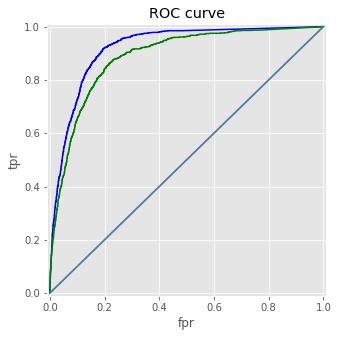

In [188]:
    # Обучаем knn
    # Гиперпараметры менял для подгтовки, которая категории заменяет количеством, а не one hot
    # Заивсимость от n_neighbors: 25 - 0,914; 50 - 0,920; 150 - 0,922
    # weights='distance' добавляет 0,03 для n_neighbors=50
    # p=1 снимает 0,01 для n_neighbors=50
knn = KNeighborsClassifier(n_neighbors=50, metric='minkowski', p=2, weights='distance')
knn.fit(x_train, y_train)
predict_knn = knn.predict(x_test)

    # Считаем ROC AUC
plt.figure(figsize=(5, 5))
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
predict_proba = knn.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, predict_proba[:,1])
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1])
print (roc_auc_score(y_test, predict_proba[:,1]))

#Для oh
knn.fit(x_train_oh, y_train_oh)
predict_knn_oh = knn.predict(x_test_oh)
predict_proba = knn.predict_proba(x_test_oh)
fpr, tpr, thresholds = roc_curve(y_test_oh, predict_proba[:,1])
plt.plot(fpr, tpr, color='green')
plt.plot([0, 1], [0, 1])
print (roc_auc_score(y_test_oh, predict_proba[:,1]))

0.9330622406639004
0.9343197637471496


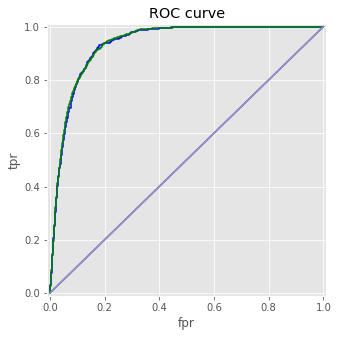

In [158]:
# То же самое для логистической регрессии
# Безразлична к методу кодирования категорий, хотя one hot на 0,001 лучше, в отличие от knn
# В целом лучшее и быстрее KNN
# Гиперпараметры: 
# class_weight = 'balanced' добавляет 0,03
# random_state не влияет, как и остальные про которые хоть что-то понял.

LR = LogisticRegression(class_weight = 'balanced')
LR.fit(x_train, y_train)
predict_LR = LR.predict(x_test)
plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
predict_proba = LR.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, predict_proba[:,1])
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1])
print (roc_auc_score(y_test, predict_proba[:,1]))

#Для oh
LR.fit(x_train_oh, y_train_oh)
predict_lr_oh = LR.predict(x_test_oh)
predict_proba = LR.predict_proba(x_test_oh)
fpr, tpr, thresholds = roc_curve(y_test_oh, predict_proba[:,1])
plt.plot(fpr, tpr, color='green')
plt.plot([0, 1], [0, 1])
print (roc_auc_score(y_test_oh, predict_proba[:,1]))

In [165]:
# Дерево принятия решений. Подбор глубины
DTC = DecisionTreeClassifier(random_state=123)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=132)

train_scores, valid_scores = validation_curve(DTC, x, y, 
                                              'max_depth', range(1, 10),
                                              cv=cv, scoring='roc_auc')

Text(0,0.5,'ROC AUC')

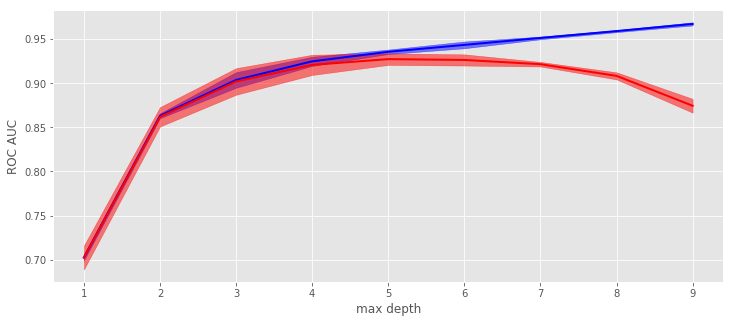

In [166]:
# Получается пять-шесть
train_score_mean = train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(1,10), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(1,10), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(range(1,10), train_score_mean, c='b', lw=2)
plt.plot(range(1,10), valid_scores_mean, c='r', lw=2)

plt.xlabel('max depth')
plt.ylabel('ROC AUC')

In [167]:
# Для подбора группы гиперпараметров
from scipy.stats import randint as randint
from scipy.stats import uniform

try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV
    from sklearn.cross_validation import StratifiedKFold


RND_SEED = 123

In [168]:
# Определим пространство поиска: состав параметров и их значений 

param_grid = {
    'criterion': ['gini', 'entropy'], # функция определения качества разбиения
    'max_depth': randint(2, 8), # максимальная глубина дерева
    'min_samples_leaf': randint(5, 10), # минимальное количество элементов в узле, при котором он будет разделяться
    'class_weight': [None, 'balanced']} # вес класса, для бинарной классификации видимо не имеет смысла?

# Некоторые параметры мы задали не простым перечислением значений, а 
# с помощью распределений.

# Будем делать 200 запусков поиска
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

model = DecisionTreeClassifier(random_state=123)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=200, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=123)
# А дальше, просто .fit()
random_search.fit(x, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
          error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best'),
          fit_params=None, iid=True, n_iter=200, n_jobs=-1,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019096A21AC8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019097671940>, 'class_weight': [None, 'balanced']},
          pre_dispatch='2*n_jobs', random_state=123, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [169]:
random_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 7}

In [170]:
random_search.best_score_

0.9357596699616268

0.9287986991140518
0.9327984000598109


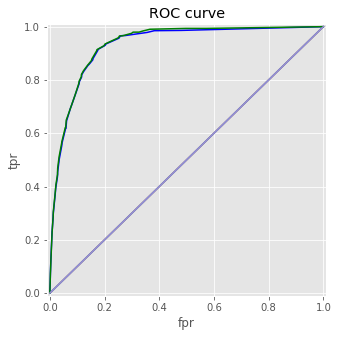

In [172]:
# Учим дерево с лушими параметрами (определены выше)
# Забавно что best_score, посчитанный выше, не совпал с посчитанным сейчас, с указанными лучшими параметрами
# Дерево, как и LR, больше любит one hot кодирование
DTC = DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 6, min_samples_leaf = 7)
DTC.fit(x_train, y_train)
predict_DTC = DTC.predict(x_test)
plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
predict_proba = DTC.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, predict_proba[:,1])
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1])
print (roc_auc_score(y_test, predict_proba[:,1]))

#Для oh
DTC.fit(x_train_oh, y_train_oh)
predict_DTC_oh = DTC.predict(x_test_oh)
predict_proba = DTC.predict_proba(x_test_oh)
fpr, tpr, thresholds = roc_curve(y_test_oh, predict_proba[:,1])
plt.plot(fpr, tpr, color='green')
plt.plot([0, 1], [0, 1])
print (roc_auc_score(y_test_oh, predict_proba[:,1]))

In [258]:
#Важность признаков
# У категориальных признаков какая-то беда со значимостью. Можно было бы попробовать:
# - признаки с нулевой значимостью вообще удалить
# - признаки с не нулевой значимостью разложить в полный one hot, без схлопывания в "прочие"
# Но, времени нет.
DTC.fit(x_train, y_train)
Feat_Imp = pd.DataFrame(columns = ['Feature', 'Imp_DTC'])
Feat_Imp['Feature'] = x_test.columns
Feat_Imp['Imp_DTC'] = DTC.feature_importances_
Feat_Imp

,Feature,Imp_DTC
0,age,0.002824
1,duration,0.477648
2,campaign,0.004142
3,pdays,0.003939
4,previous,0.002424
5,emp.var.rate,0.037352
6,cons.price.idx,0.001548
7,cons.conf.idx,0.000000
8,euribor3m,0.035379
9,nr.employed,0.288899


In [173]:
#===ВОПРОС==== Обещали, что DTC работает с категориями, а тут ругается на строку. Гугл ответов не дал, кроме того, что не у меня одного такой вопрос.
x_s = df.drop('target', axis=1)
y_s = df['target']
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x_s, y_s, test_size=0.33, random_state=42)

DTC = DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 6, min_samples_leaf = 7)
DTC.fit(x_train_s, y_train_s)
predict_DTC = DTC.predict(x_test_s)
plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
predict_proba = DTC.predict_proba(x_test_s)
fpr, tpr, thresholds = roc_curve(y_test_s, predict_proba[:,1])
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1])
print (roc_auc_score(y_test_s, predict_proba[:,1]))

ValueError: could not convert string to float: 'nonexistent'

In [190]:
# Делаем оценку для тестовых данных
# Лучшая модель получилась линейная регресия с кодировкой категорий one hot
LR.fit(x_train_oh, y_train_oh)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=True)

In [243]:
# ВАЖНО! Нельзя в подгтовке данных динамически схлапывать категории, в частности по правилам "<10% идут в "Прочие"" или "Топ-5"
# Потому что в тестовых данных состав категорий притаком подходе может оказаться ДРУГОЙ!
# Надо  фиксировать полученные новые категории и работать только с ними 
# Сейчас, к сожеланию, нет времени писать правильный код, поэтому просто удалю новую постороннюю категорию в тестовом массиве
df_test = pd.read_csv('test.csv', sep=',', header = 0, index_col = 0, encoding='utf8')
df_test = preproc_oh(df_test)
df_test = df_test.drop('month=nov', axis = 1)
df_test['target'] = LR.predict(df_test)
Submission = df_test['target']

In [246]:
#Сохраняем предсказание
Submission.to_csv('hw3_Submission.csv', header = True, index = True, index_label = '_id', sep = ',', encoding = 'utf-8')